# 02 — EDA: Exploratory Data Analysis

Load pre-ingested datasets (Check Expert intraday + FnGuide daily) for research.

In [1]:
from pathlib import Path

import fn_dg6_ingest
from utils.chkxp_ingest import open as chkxp_open

## Load Datasets

### Check Expert (intraday)

In [2]:
RAW_DIR = Path("../data/raw/chkxp")
DB_DIR  = Path("../data/db/chkxp")

_kodex200_path = RAW_DIR / "chkxp_etf(kodex200)_(1m)_ohlcvNAV.csv"
_semi_path     = RAW_DIR / "chkxp_etc(tiger반도체top10)_(1m)_ohlcvNAV.csv"
_kp200_path    = RAW_DIR / "kp200_(fut)(mini)(v)_(1m)_from(20250101)_to(20260207).csv"

ds_kodex200  = chkxp_open(str(_kodex200_path), output_dir=str(DB_DIR / _kodex200_path.stem))
ds_semi      = chkxp_open(str(_semi_path),     output_dir=str(DB_DIR / _semi_path.stem))
ds_kp200     = chkxp_open(str(_kp200_path),    output_dir=str(DB_DIR / _kp200_path.stem))

df_kodex200  = ds_kodex200.load()
df_semi      = ds_semi.load()
df_kp200     = ds_kp200.load()

### FnGuide DataGuide (daily)

In [3]:
FN_RAW_DIR = Path("../data/raw/fnguide")
FN_DB_DIR  = Path("../data/db/fnguide")

fn_ohlcv_path      = FN_RAW_DIR / "dataguide_kse+kosdaq_ohlcv_from(20160101)_to(20260207).csv"
fn_etfc_kodex_path  = FN_RAW_DIR / "dataguide_etfconst(kodex200)_from(20250101)_to(20260207).csv"
fn_etfc_semi_path   = FN_RAW_DIR / "dataguide_etfconst(tiger반도체top10)_from(20250101)_to(20260218).csv"

ds_fn_ohlcv      = fn_dg6_ingest.open(str(fn_ohlcv_path),     output_dir=str(FN_DB_DIR / fn_ohlcv_path.stem))
ds_fn_etfc_kodex = fn_dg6_ingest.open(str(fn_etfc_kodex_path), output_dir=str(FN_DB_DIR / fn_etfc_kodex_path.stem))
ds_fn_etfc_semi  = fn_dg6_ingest.open(str(fn_etfc_semi_path),  output_dir=str(FN_DB_DIR / fn_etfc_semi_path.stem))

df_fn_ohlcv      = ds_fn_ohlcv.load()
df_fn_etfc_kodex = ds_fn_etfc_kodex.load()
df_fn_etfc_semi  = ds_fn_etfc_semi.load()

## Preprocessing

### Drop NaT rows & add return columns

In [4]:
for df in (df_kodex200, df_semi, df_kp200):
    df.dropna(subset=["datetime"], inplace=True)

print(f"df_kodex200: {len(df_kodex200):,}  |  df_semi: {len(df_semi):,}  |  df_kp200: {len(df_kp200):,}")

df_kodex200: 23,730  |  df_semi: 24,057  |  df_kp200: 786,380


In [5]:
_RETURN_COLS = {
    "Intra종가":                    "Intra종가수익률",
    "Intra장중지표가치(iNAV/iIV)종가": "IntraiNAV종가수익률",
    "IntraETP기초지수":              "IntraETP기초지수변화율",
}

for df in (df_kodex200, df_semi, df_kp200):
    df.sort_values(["entity", "datetime"], inplace=True)
    df["date"] = df["datetime"].dt.date
    for src, dst in _RETURN_COLS.items():
        if src in df.columns:
            df[dst] = df.groupby(["entity", "date"])[src].pct_change()

In [6]:
df_kodex200['IntraETP괴리율'] = df_kodex200['IntraETP괴리율'] / 100
df_kodex200['Intra추적오차율'] = df_kodex200['Intra추적오차율'] / 100

df_semi['IntraETP괴리율'] = df_semi['IntraETP괴리율'] / 100
df_semi['Intra추적오차율'] = df_semi['Intra추적오차율'] / 100


## KODEX 200 ETF — Intraday Time Series

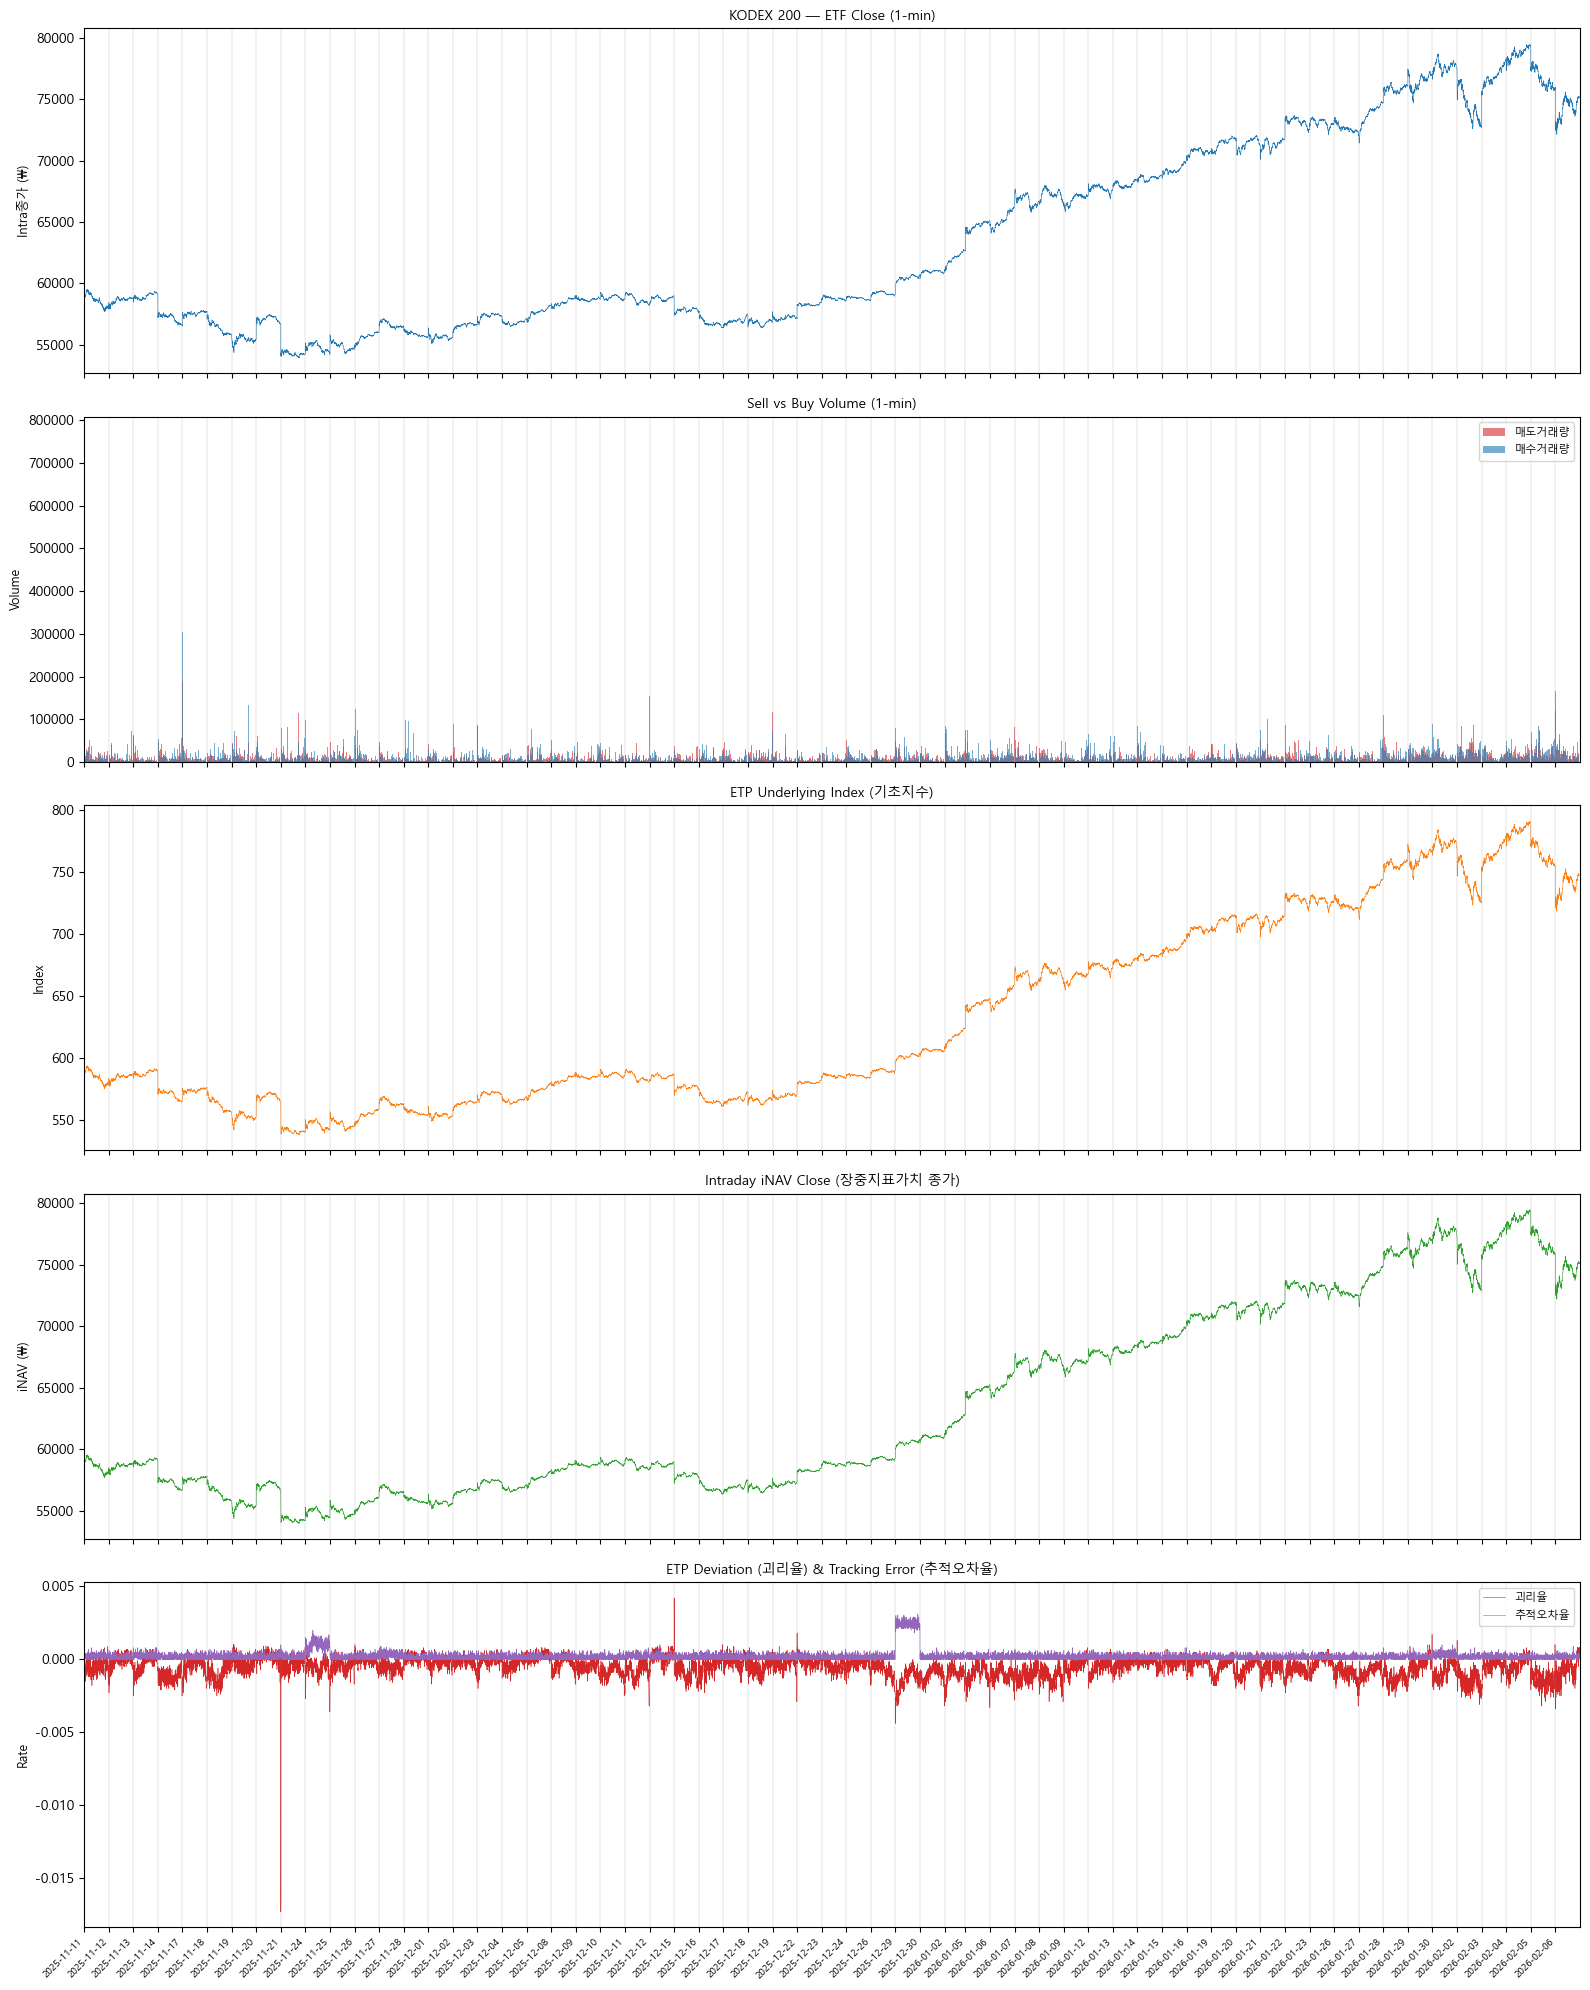

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# --- Ordinal x-axis + day boundary detection ---
df_k = df_kodex200.reset_index(drop=True)
x = np.arange(len(df_k))

dates = df_k["datetime"].dt.date
day_change = (dates != dates.shift(1))
boundary_idx = df_k.index[day_change].tolist()

tick_labels = [str(dates.iloc[i]) for i in boundary_idx]

def _style_ax(ax, title, ylabel):
    """Apply day-boundary lines and ordinal x-tick labels."""
    for bi in boundary_idx:
        ax.axvline(bi, color="grey", linewidth=0.3, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=9)

fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True)

# 1 — ETF Close
ax = axes[0]
ax.plot(x, df_k["Intra종가"], linewidth=0.4, color="C0")
_style_ax(ax, "KODEX 200 — ETF Close (1-min)", "Intra종가 (₩)")

# 2 — Sell / Buy Volume
ax = axes[1]
ax.bar(x, df_k["Intra매도거래량"], width=1.0, color="C3", alpha=0.6, label="매도거래량")
ax.bar(x, df_k["Intra매수거래량"], width=1.0, color="C0", alpha=0.6, label="매수거래량")
_style_ax(ax, "Sell vs Buy Volume (1-min)", "Volume")
ax.legend(loc="upper right", fontsize=8)

# 3 — Underlying Index
ax = axes[2]
ax.plot(x, df_k["IntraETP기초지수"], linewidth=0.4, color="C1")
_style_ax(ax, "ETP Underlying Index (기초지수)", "Index")

# 4 — iNAV Close
ax = axes[3]
ax.plot(x, df_k["Intra장중지표가치(iNAV/iIV)종가"], linewidth=0.4, color="C2")
_style_ax(ax, "Intraday iNAV Close (장중지표가치 종가)", "iNAV (₩)")

# 5 — Deviation & Tracking Error
ax = axes[4]
ax.plot(x, df_k["IntraETP괴리율"], linewidth=0.4, color="C3", label="괴리율")
ax.plot(x, df_k["Intra추적오차율"], linewidth=0.4, color="C4", label="추적오차율")
_style_ax(ax, "ETP Deviation (괴리율) & Tracking Error (추적오차율)", "Rate")
ax.legend(loc="upper right", fontsize=8)

# --- Shared x-axis: date labels at session boundaries ---
axes[-1].set_xticks(boundary_idx)
axes[-1].set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=7)
axes[-1].set_xlim(0, len(df_k))

fig.tight_layout()
plt.show()

### Single-day deep dive

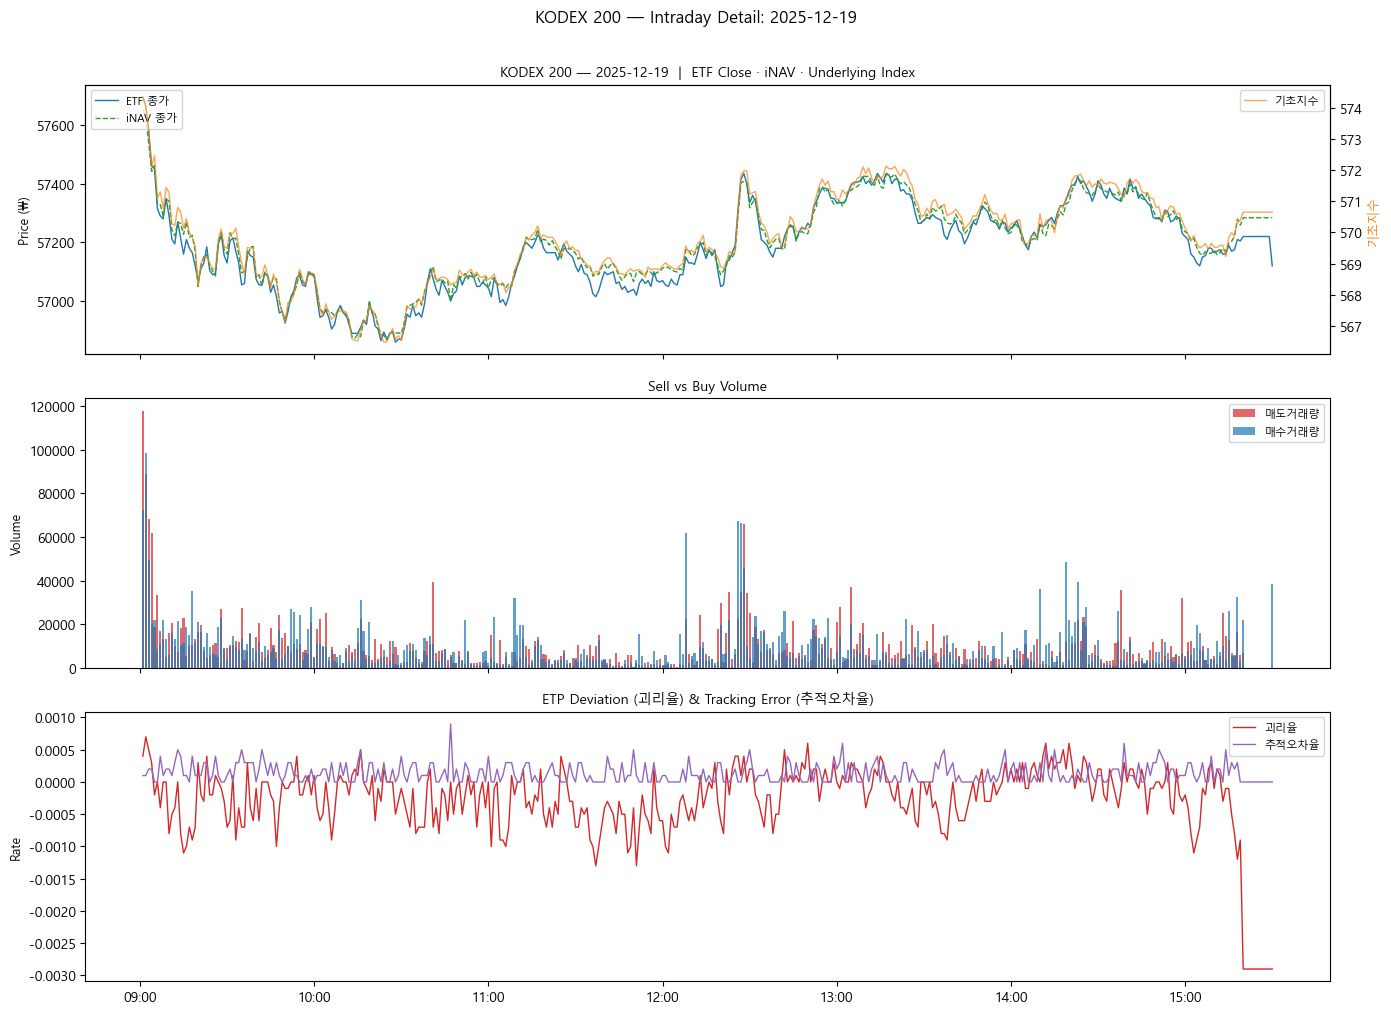

Sampled date: 2025-12-19  |  390 bars


In [8]:
import random

unique_dates = sorted(df_kodex200["date"].unique())
mid = len(unique_dates) // 2
sample_date = random.choice(unique_dates[mid - 2 : mid + 3])

day = df_kodex200[df_kodex200["date"] == sample_date].copy()
t = day["datetime"]

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1 — ETF Close + Underlying Index + iNAV (dual y-axis)
ax1 = axes[0]
ax1.plot(t, day["Intra종가"], linewidth=1.0, color="C0", label="ETF 종가")
ax1.plot(t, day["Intra장중지표가치(iNAV/iIV)종가"], linewidth=1.0, color="C2", linestyle="--", label="iNAV 종가")
ax1.set_ylabel("Price (₩)", fontsize=9)
ax1.legend(loc="upper left", fontsize=8)

ax1r = ax1.twinx()
ax1r.plot(t, day["IntraETP기초지수"], linewidth=1.0, color="C1", alpha=0.7, label="기초지수")
ax1r.set_ylabel("기초지수", fontsize=9, color="C1")
ax1r.legend(loc="upper right", fontsize=8)

ax1.set_title(f"KODEX 200 — {sample_date}  |  ETF Close · iNAV · Underlying Index", fontsize=10)

# 2 — Sell / Buy Volume
ax = axes[1]
ax.bar(t, day["Intra매도거래량"], width=0.0005, color="C3", alpha=0.7, label="매도거래량")
ax.bar(t, day["Intra매수거래량"], width=0.0005, color="C0", alpha=0.7, label="매수거래량")
ax.set_ylabel("Volume", fontsize=9)
ax.set_title("Sell vs Buy Volume", fontsize=10)
ax.legend(loc="upper right", fontsize=8)

# 3 — Deviation & Tracking Error
ax = axes[2]
ax.plot(t, day["IntraETP괴리율"], linewidth=1.0, color="C3", label="괴리율")
ax.plot(t, day["Intra추적오차율"], linewidth=1.0, color="C4", label="추적오차율")
ax.set_ylabel("Rate", fontsize=9)
ax.set_title("ETP Deviation (괴리율) & Tracking Error (추적오차율)", fontsize=10)
ax.legend(loc="upper right", fontsize=8)

import matplotlib.dates as mdates
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axes[-1].tick_params(axis="x", rotation=0)

fig.suptitle(f"KODEX 200 — Intraday Detail: {sample_date}", fontsize=12, y=1.01)
fig.tight_layout()
fig.savefig("../outputs/assets/lp_kodex200_intraday_detail.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Sampled date: {sample_date}  |  {len(day)} bars")

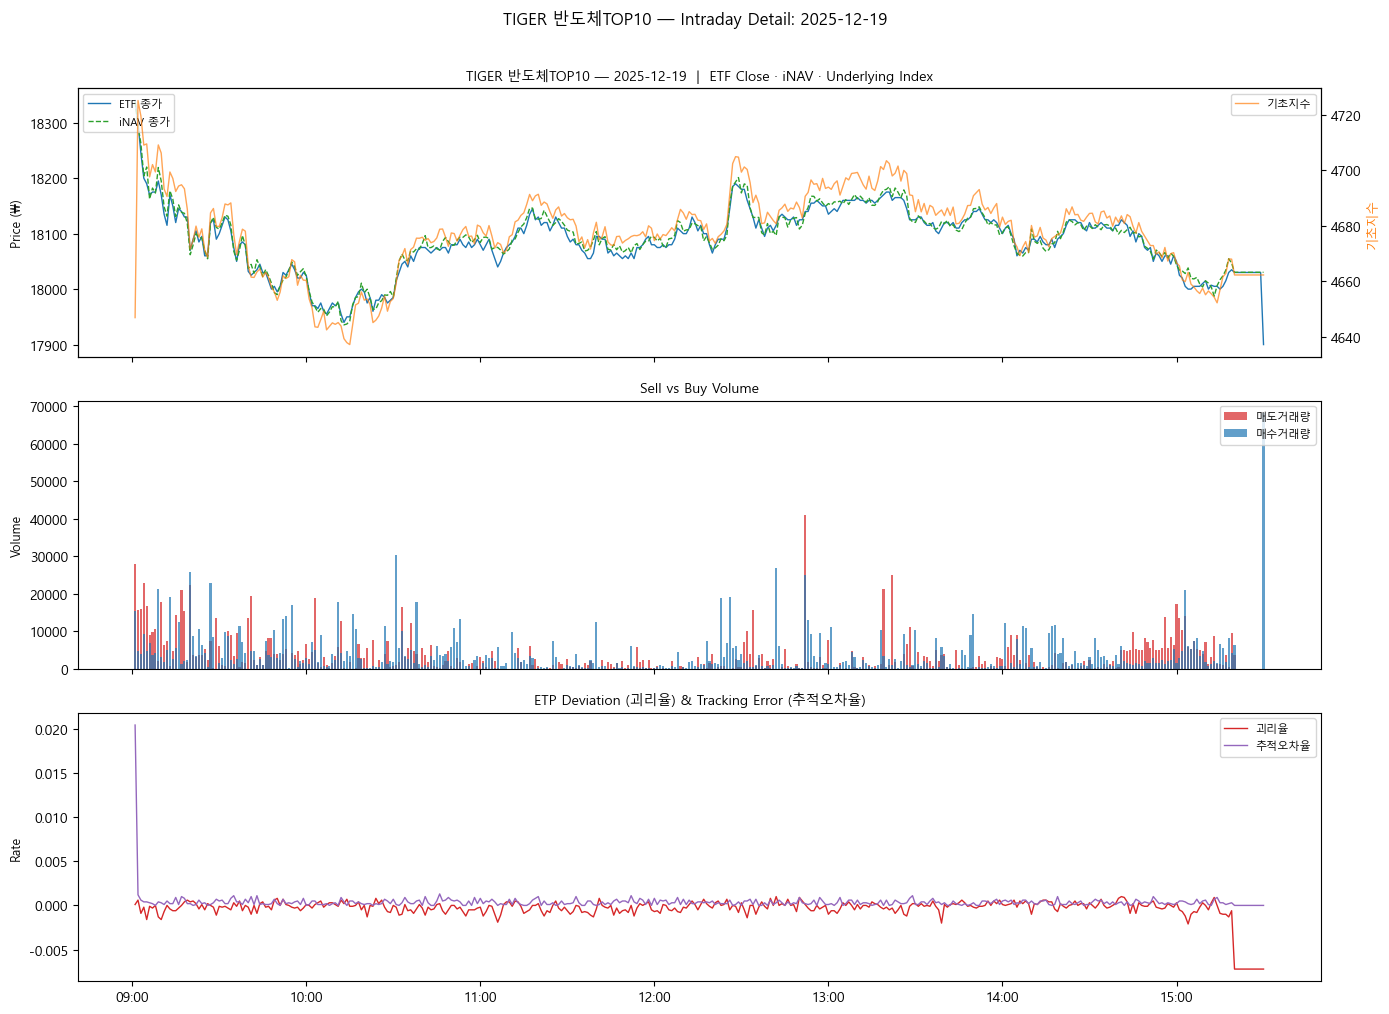

Sampled date: 2025-12-19  |  390 bars


In [9]:
day_semi = df_semi[df_semi["date"] == sample_date].copy()
t_semi = day_semi["datetime"]

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1 — ETF Close + Underlying Index + iNAV (dual y-axis)
ax1 = axes[0]
ax1.plot(t_semi, day_semi["Intra종가"], linewidth=1.0, color="C0", label="ETF 종가")
ax1.plot(t_semi, day_semi["Intra장중지표가치(iNAV/iIV)종가"], linewidth=1.0, color="C2", linestyle="--", label="iNAV 종가")
ax1.set_ylabel("Price (₩)", fontsize=9)
ax1.legend(loc="upper left", fontsize=8)

ax1r = ax1.twinx()
ax1r.plot(t_semi, day_semi["IntraETP기초지수"], linewidth=1.0, color="C1", alpha=0.7, label="기초지수")
ax1r.set_ylabel("기초지수", fontsize=9, color="C1")
ax1r.legend(loc="upper right", fontsize=8)

ax1.set_title(f"TIGER 반도체TOP10 — {sample_date}  |  ETF Close · iNAV · Underlying Index", fontsize=10)

# 2 — Sell / Buy Volume
ax = axes[1]
ax.bar(t_semi, day_semi["Intra매도거래량"], width=0.0005, color="C3", alpha=0.7, label="매도거래량")
ax.bar(t_semi, day_semi["Intra매수거래량"], width=0.0005, color="C0", alpha=0.7, label="매수거래량")
ax.set_ylabel("Volume", fontsize=9)
ax.set_title("Sell vs Buy Volume", fontsize=10)
ax.legend(loc="upper right", fontsize=8)

# 3 — Deviation & Tracking Error
ax = axes[2]
ax.plot(t_semi, day_semi["IntraETP괴리율"], linewidth=1.0, color="C3", label="괴리율")
ax.plot(t_semi, day_semi["Intra추적오차율"], linewidth=1.0, color="C4", label="추적오차율")
ax.set_ylabel("Rate", fontsize=9)
ax.set_title("ETP Deviation (괴리율) & Tracking Error (추적오차율)", fontsize=10)
ax.legend(loc="upper right", fontsize=8)

axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axes[-1].tick_params(axis="x", rotation=0)

fig.suptitle(f"TIGER 반도체TOP10 — Intraday Detail: {sample_date}", fontsize=12, y=1.01)
fig.tight_layout()
fig.savefig("../outputs/assets/lp_tiger_semiconductor_intraday_detail.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Sampled date: {sample_date}  |  {len(day_semi)} bars")